In [1]:
from data.loader import load_dataset, load_train_dataset
from models.u2net import U2NET

from IPython.display import clear_output
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import keras
import os

from keras.metrics import Accuracy, MeanSquaredError, MeanIoU

tf.debugging.disable_traceback_filtering()

In [2]:
TRAIN_PATH = "./datasets/DUTS-TR/"
TEST_PATH = "./datasets/DUTS-TE/"

IMAGE_SHAPE = (320, 320, 3)
MASK_SHAPE = (320, 320, 1)

# Training
BATCH_SIZE = 8
EPOCHS = 80
LEARNING_RATE = 0.001

In [3]:
def display(display_list, titles):
    assert len(display_list) == len(titles), "Размер списка изображений должен соотвествовать размеру списка заголовков"
    
    plt.figure(figsize=(12, 12))
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.show()

In [4]:
train_dataset = load_train_dataset(
    images_dir_path = os.path.join(TRAIN_PATH, "Image/*"),
    masks_dir_path = os.path.join(TRAIN_PATH, "Mask/*"),
    image_shape = IMAGE_SHAPE,
    mask_shape = MASK_SHAPE,
    batch=BATCH_SIZE,
)

test_dataset = load_dataset(
    images_dir_path = os.path.join(TEST_PATH, "Image/*"),
    masks_dir_path = os.path.join(TEST_PATH, "Mask/*"),
    image_shape = IMAGE_SHAPE,
    mask_shape = MASK_SHAPE
).batch(BATCH_SIZE)

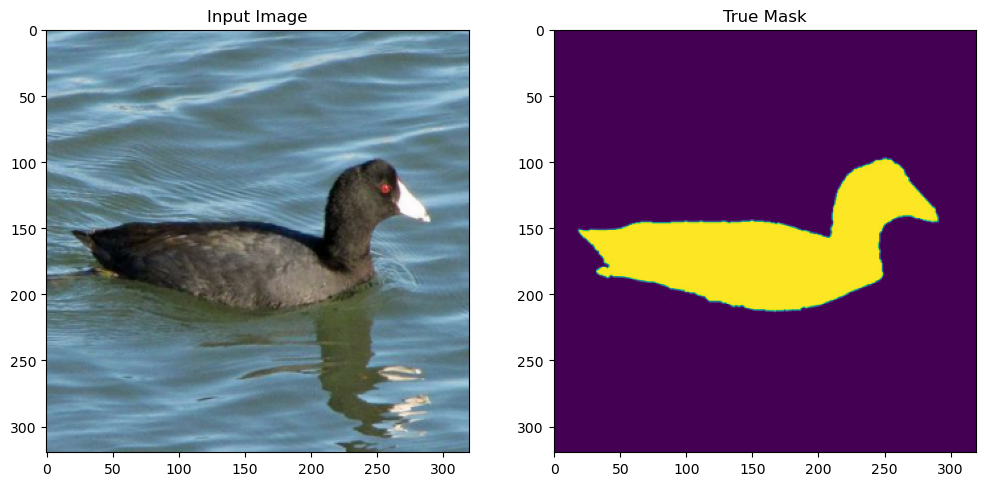

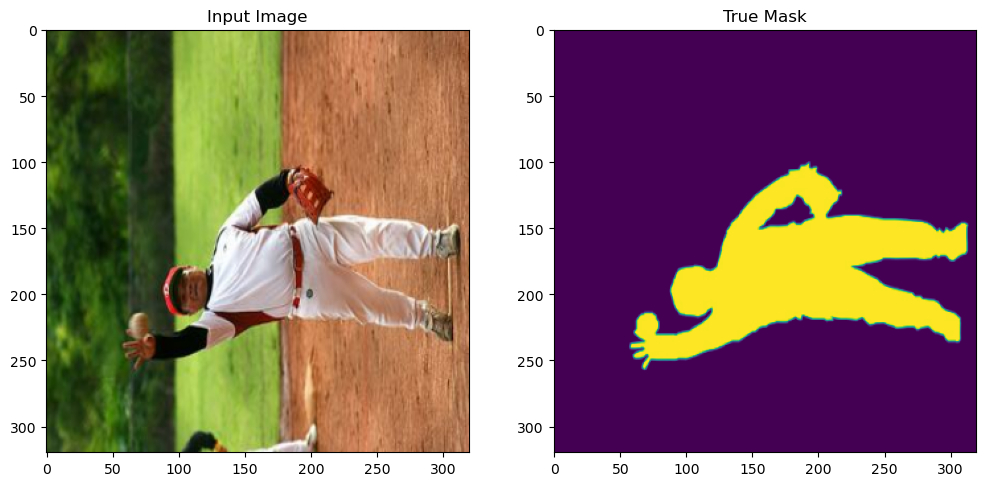

In [5]:
for images, masks in train_dataset.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask], ['Input Image', 'True Mask'])

In [6]:
# Изображение для отладки обучения
for images, masks in test_dataset.take(1):
    test_image_for_display = images[6]
    test_mask_for_display = masks[6]

In [7]:
class RoundedAccuracy(Accuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.round(y_pred)
        return super(RoundedAccuracy,self).update_state(y_true, y_pred, sample_weight)
    
class RoundedMeanIoU(MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.round(y_pred)
        return super(RoundedMeanIoU,self).update_state(y_true, y_pred, sample_weight)

In [8]:
adam = keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=.9, beta_2=.999, epsilon=1e-08)
bce = keras.losses.BinaryCrossentropy()

model = U2NET(shape_image=IMAGE_SHAPE)
model.compile(optimizer=adam, loss=bce, metrics=[[RoundedAccuracy(), MeanSquaredError(), RoundedMeanIoU(num_classes=2)]] + [None] * 6)

In [9]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, mask, freq):
        super().__init__() 
        self.freq = freq
        self.image = image
        self.mask = mask
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.freq == 0 or epoch == EPOCHS-1:
            out = self.model(tf.expand_dims(self.image, axis=0))
            print ('\nSample Prediction after epoch {}\n'.format(epoch + 1))
            display(
                [self.image, self.mask, out[0][0], tf.math.round(out[0][0])],
                ["Input image", "True mask", "Predicted mask", "Rounded mask"]
            )


Sample Prediction after epoch 1



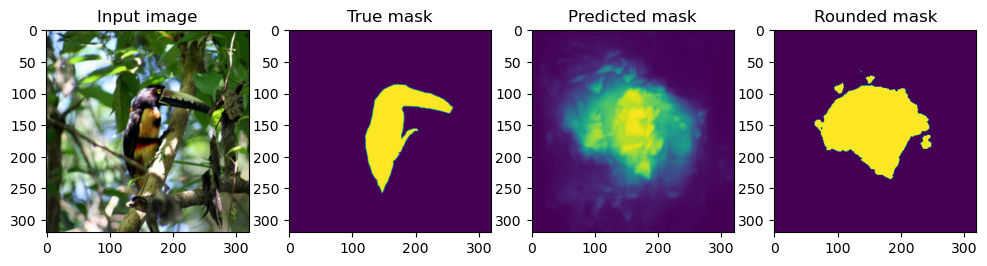


Sample Prediction after epoch 11



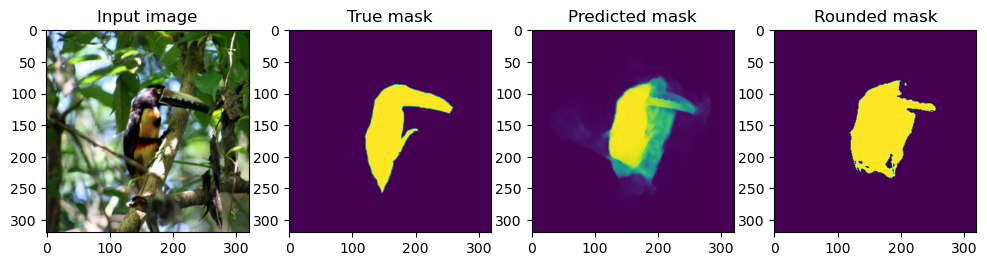


Sample Prediction after epoch 21



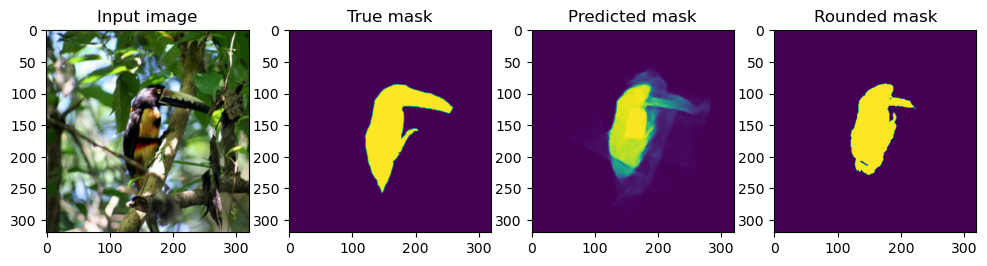


Sample Prediction after epoch 31



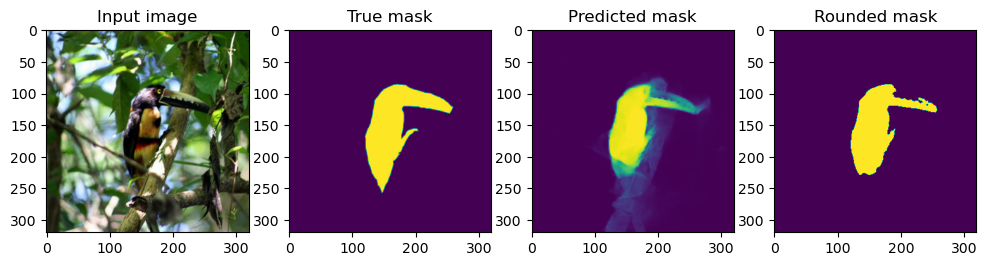


Sample Prediction after epoch 41



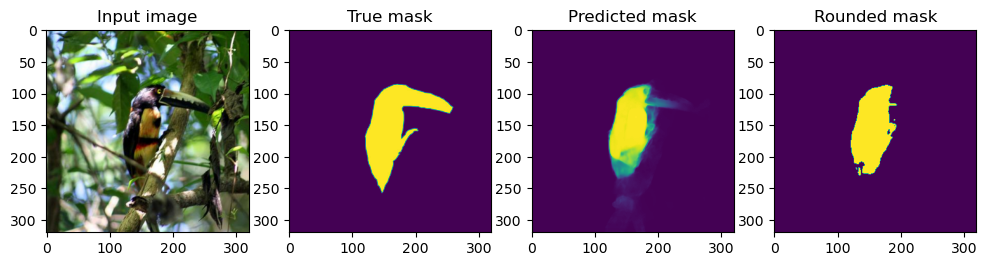


Sample Prediction after epoch 51



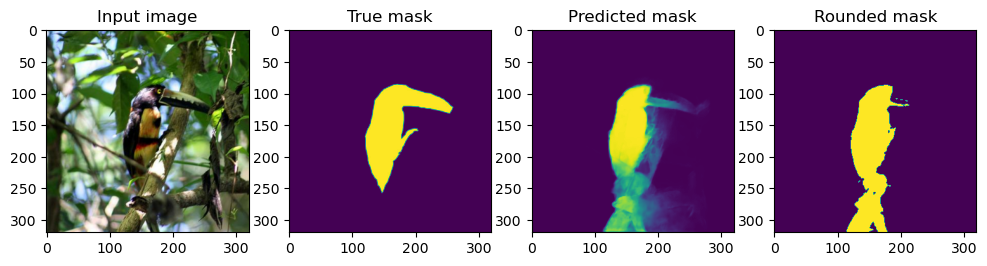


Sample Prediction after epoch 61



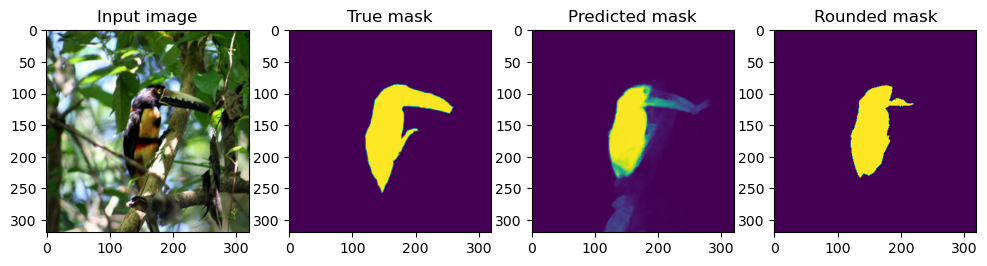


Sample Prediction after epoch 71



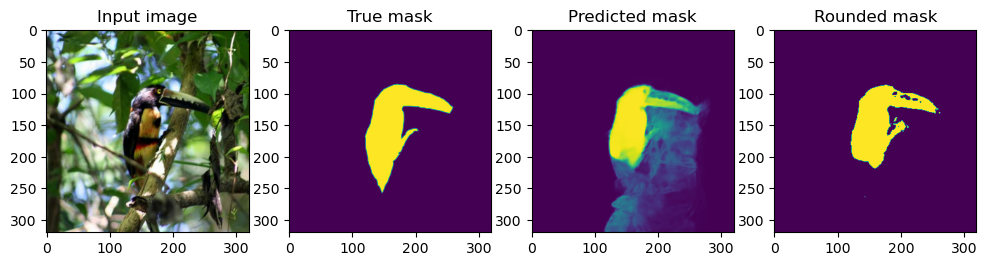


Sample Prediction after epoch 80



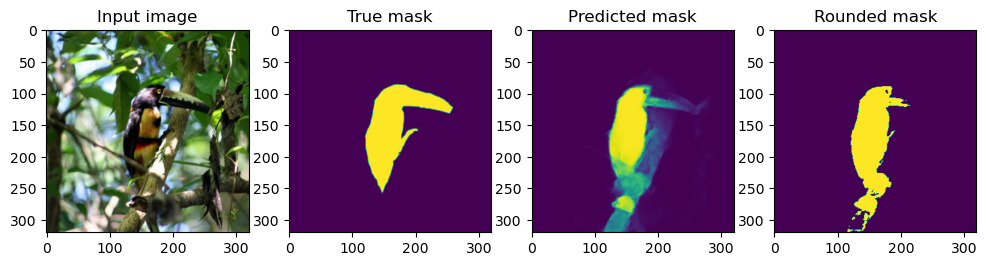

In [11]:
callbacks = [
    keras.callbacks.TensorBoard(log_dir="./logs"),
    keras.callbacks.BackupAndRestore("./bkp"),
    DisplayCallback(test_image_for_display, test_mask_for_display, 10),
]

history = model.fit(train_dataset, validation_data=test_dataset, callbacks=callbacks, epochs=EPOCHS, verbose=0)
model.save('u2net.h5', include_optimizer=False)

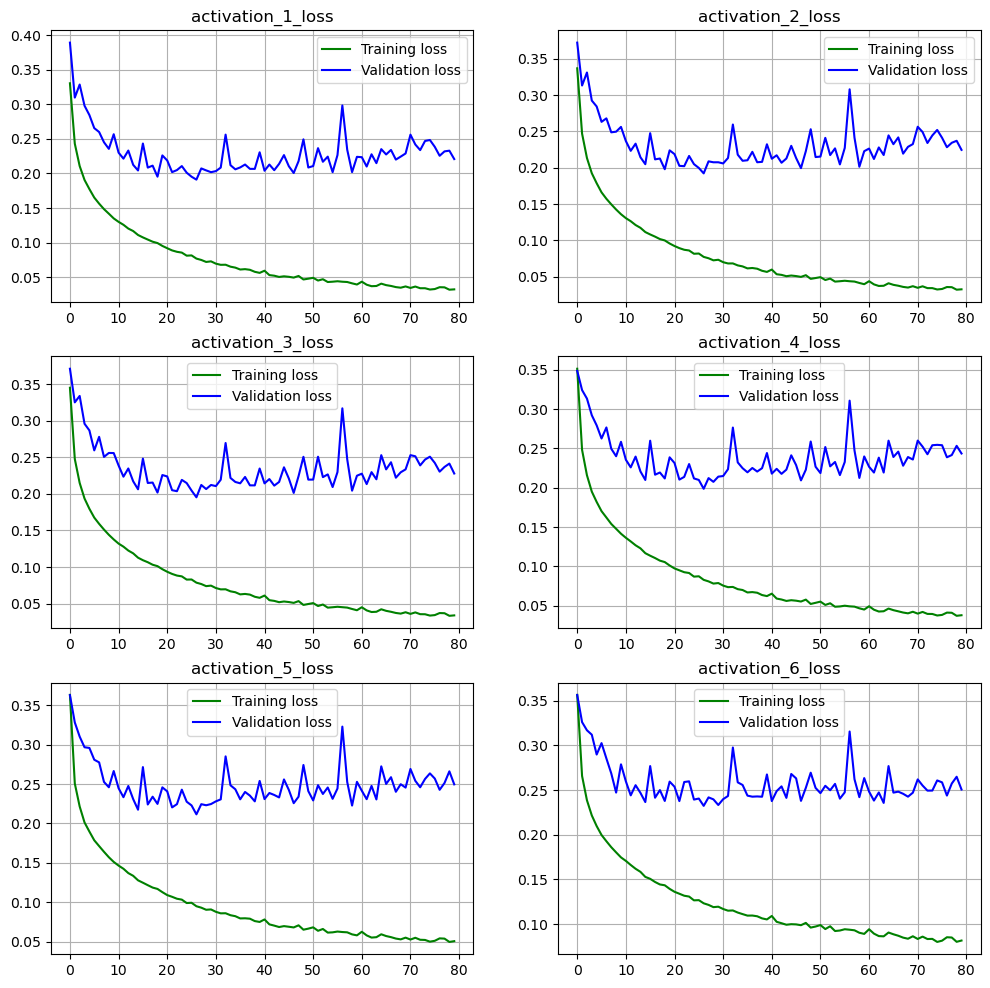

In [12]:
# loss outputs
loss_titles_list = ["activation_" + str(i) + "_loss" for i in range(1, 7)]

fig, axs = plt.subplots(3, 2, figsize=(12,12))
axs = axs.ravel()

for i, loss_name in enumerate(loss_titles_list):
    loss = history.history[loss_name]
    val_loss = history.history['val_' + loss_name]
    
    axs[i].plot(history.epoch, loss, 'g', label='Training loss')
    axs[i].plot(history.epoch, val_loss, 'b', label='Validation loss')
    axs[i].set_title(loss_name)
    axs[i].legend()
    axs[i].grid()

plt.show()

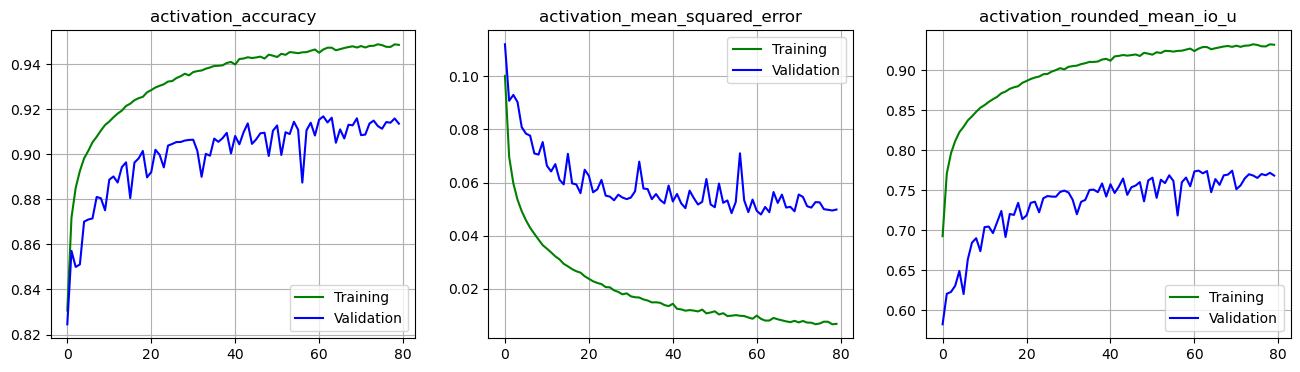

In [13]:
# metrics
metrics_titles_list = ["activation_accuracy", "activation_mean_squared_error", "activation_rounded_mean_io_u"]

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs = axs.ravel()

for i, metrics_name in enumerate(metrics_titles_list):
    metrics = history.history[metrics_name]
    val_metrics = history.history['val_' + metrics_name]
    
    axs[i].plot(history.epoch, metrics, 'g', label='Training')
    axs[i].plot(history.epoch, val_metrics, 'b', label='Validation')
    axs[i].set_title(metrics_name)
    axs[i].legend()
    axs[i].grid()

plt.show()

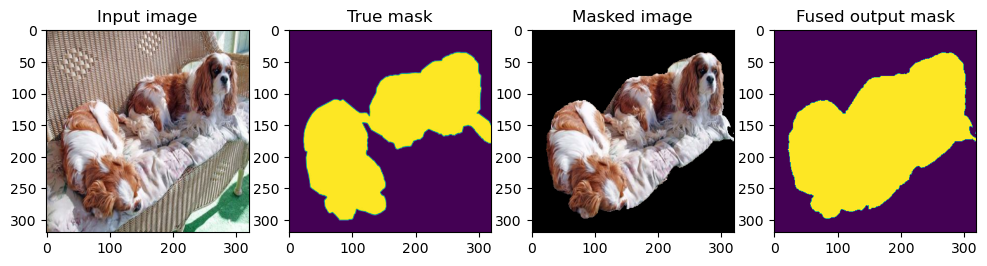

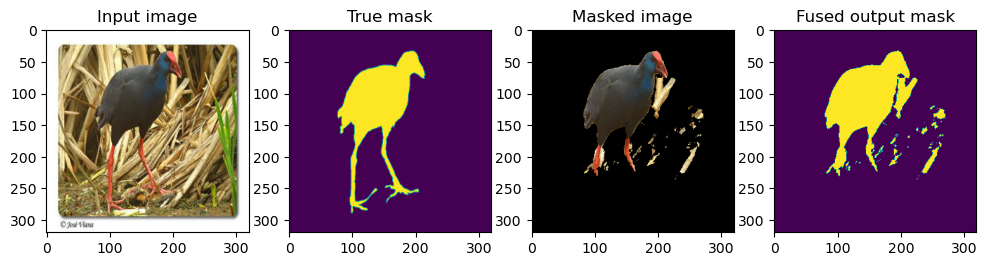

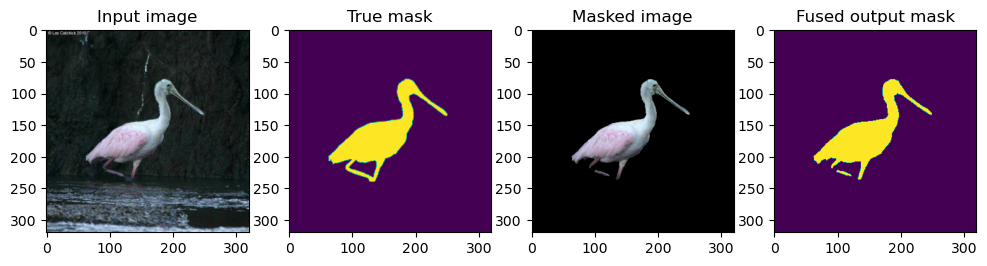

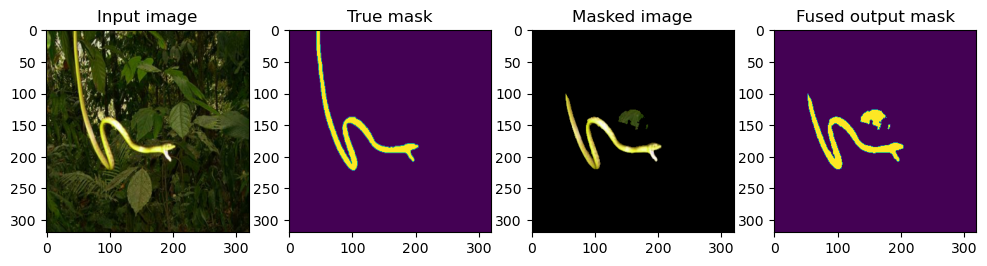

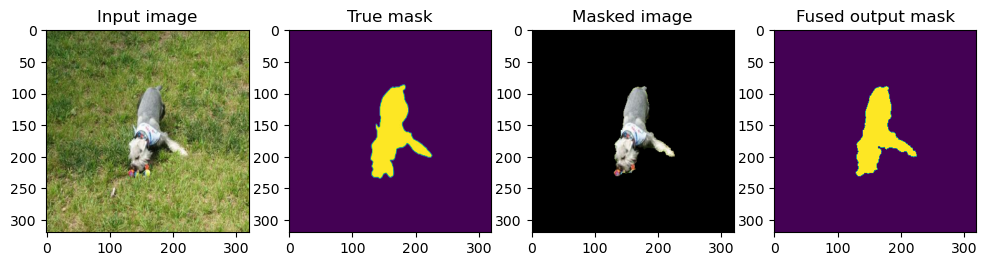

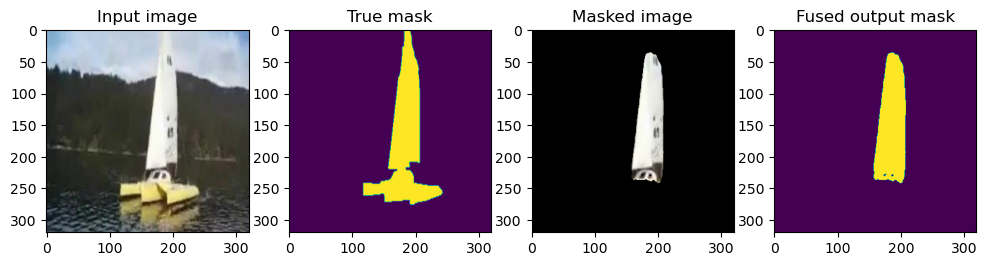

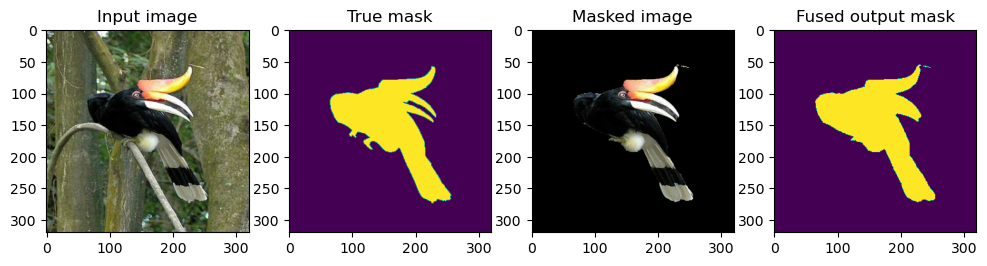

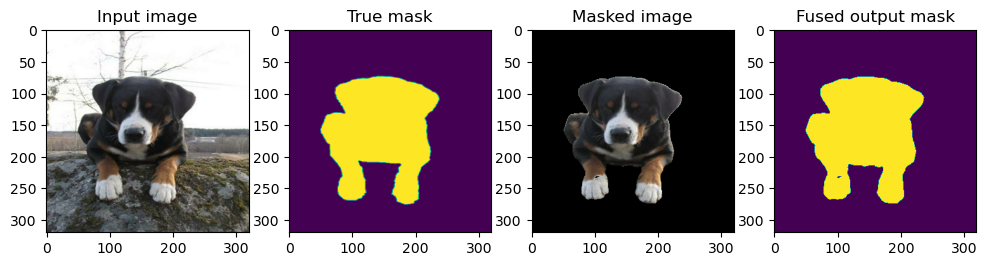

In [20]:
for image, mask in test_dataset.shuffle(80).take(1):
    out = model(image)
    for i in range(len(image)):
        out_mask = tf.math.round(out[0][i])
        display(
            [image[i], mask[i], np.multiply(image[i], out_mask), out_mask],
            ["Input image", "True mask", "Masked image", "Fused output mask"]
        )

In [9]:
saved_model = U2NET(shape_image=IMAGE_SHAPE)
saved_model.load_weights('u2net.h5')